In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stat
from scipy.optimize import minimize
import os
import json, ast
import math
import scipy.io
import mat4py
from scipy.ndimage import gaussian_filter


In [29]:
num_participants = 60
num_blocks = 12
num_trials = 64
participants = np.arange(1000, 1000 + num_participants)
blocks = np.arange(0, num_blocks)
cursor_trajectory = []
for participant in participants:
    for block in blocks:
        temp =  scipy.io.loadmat(f'Data/data{participant}/actual_trajectories/trajectories{block}.mat')
        for trial in np.arange(num_trials):
            cursor_trajectory.append(np.array((temp['x'].T[trial][0], temp['y'].T[trial][0])).T.reshape(temp['x'].T[trial][0].shape[1], 2))



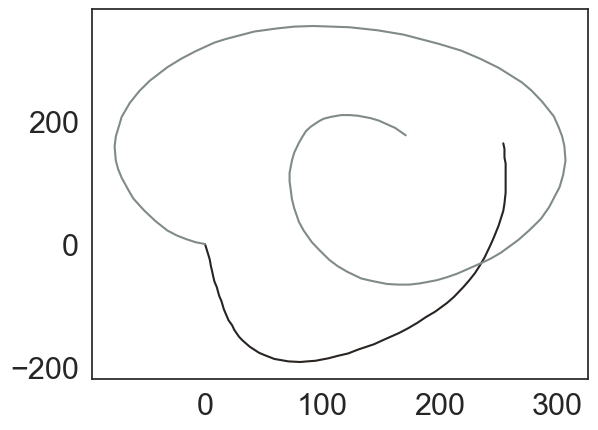

In [27]:
i = 65
plt.plot(cursor_trajectory[i][:, 0], cursor_trajectory[i][:, 1])
i = 652
plt.plot(cursor_trajectory[i][:, 0], cursor_trajectory[i][:, 1])


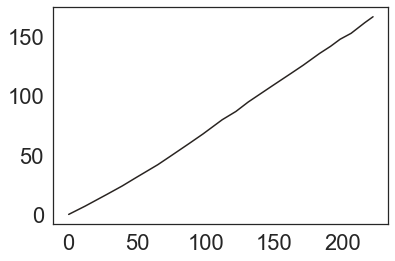

In [281]:
for i in range(i):
    plt.plot(cursor_trajectory[i][:, 0], cursor_trajectory[i][:, 1])
    # plt.plot(cursor_trajectory[i])

In [4]:
df = pd.DataFrame({'p_id' : np.repeat(np.arange(num_participants), num_blocks*num_trials),
                    'Trial': np.tile(np.arange(768), 60),
                    'Block': np.tile(np.repeat(np.arange(12), 64), 60), 
                    'Rotation': np.tile(np.repeat(np.array(['Sudden', 'Sudden', 'Gradual', 'Gradual']), 768), 15),
                    'Emphasis': np.tile(np.repeat(np.array(['Speed', 'Accuracy']), 768), 30),
                #    'cursor trajectory': np.array(cursor_trajectory, dtype = object)
})

In [160]:
df.to_csv('all_trajectories.csv')

In [5]:
def find_angles(a, b, c):

  # Calculate the vectors ab and ac for each triplet of points.
  ab = a - b
  ac = a - c

  # cosine_angle = np.dot(ab, ac) / (np.linalg.norm(ab) * np.linalg.norm(ac))
  # angle = np.arccos(cosine_angle)
  # signed_angle = np.arctan2(ba[1],ba[0]) - np.arctan2(bc[1],bc[0])

  angles = []
  for v1, v2 in zip(ab, ac):
    dotprod = np.dot(np.abs(v1), np.abs(v2))
    ab_magnitudes = np.linalg.norm(np.abs(v1))
    ac_magnitudes = np.linalg.norm(np.abs(v2))
    crossprod = np.cross(v1, v2)
    if crossprod < 0:
      sign = -1
    else:
      sign = 1

  # # print(dot_products.shape)
  # # Calculate the angles between ab and ac.
    angles.append(np.arccos(dotprod / (ab_magnitudes * ac_magnitudes)))

  return np.nanmean(angles)

def comp_avg_ang_error(traj):
    # try:
    # print(traj)
    traj = traj.astype(float)
    
    end_point = traj[-1]
    curr_point = np.array(traj[:-1])/np.abs(end_point)
    next_point = np.array(traj[1:])/np.abs(end_point)
    
    angles = find_angles(curr_point, end_point, next_point)

    
    return angles
    # except:
    #     return np.NaN

In [6]:
avg_errors = []
for traj in cursor_trajectory:
    avg_errors.append(comp_avg_ang_error(traj))

C:\Users\tejas\AppData\Local\Temp\ipykernel_19316\226090205.py:24: RuntimeWarning: invalid value encountered in double_scalars
  angles.append(np.arccos(dotprod / (ab_magnitudes * ac_magnitudes)))
C:\Users\tejas\AppData\Local\Temp\ipykernel_19316\226090205.py:24: RuntimeWarning: invalid value encountered in arccos
  angles.append(np.arccos(dotprod / (ab_magnitudes * ac_magnitudes)))


In [7]:
df['avg errors'] = np.array(avg_errors)
# df.loc[(df['init signed error'] < 0), 'signed avg errors'] = -df.loc[(df['init signed error'] < 0), 'signed avg errors']
df['avg errors degrees'] = df['avg errors']*180/np.pi


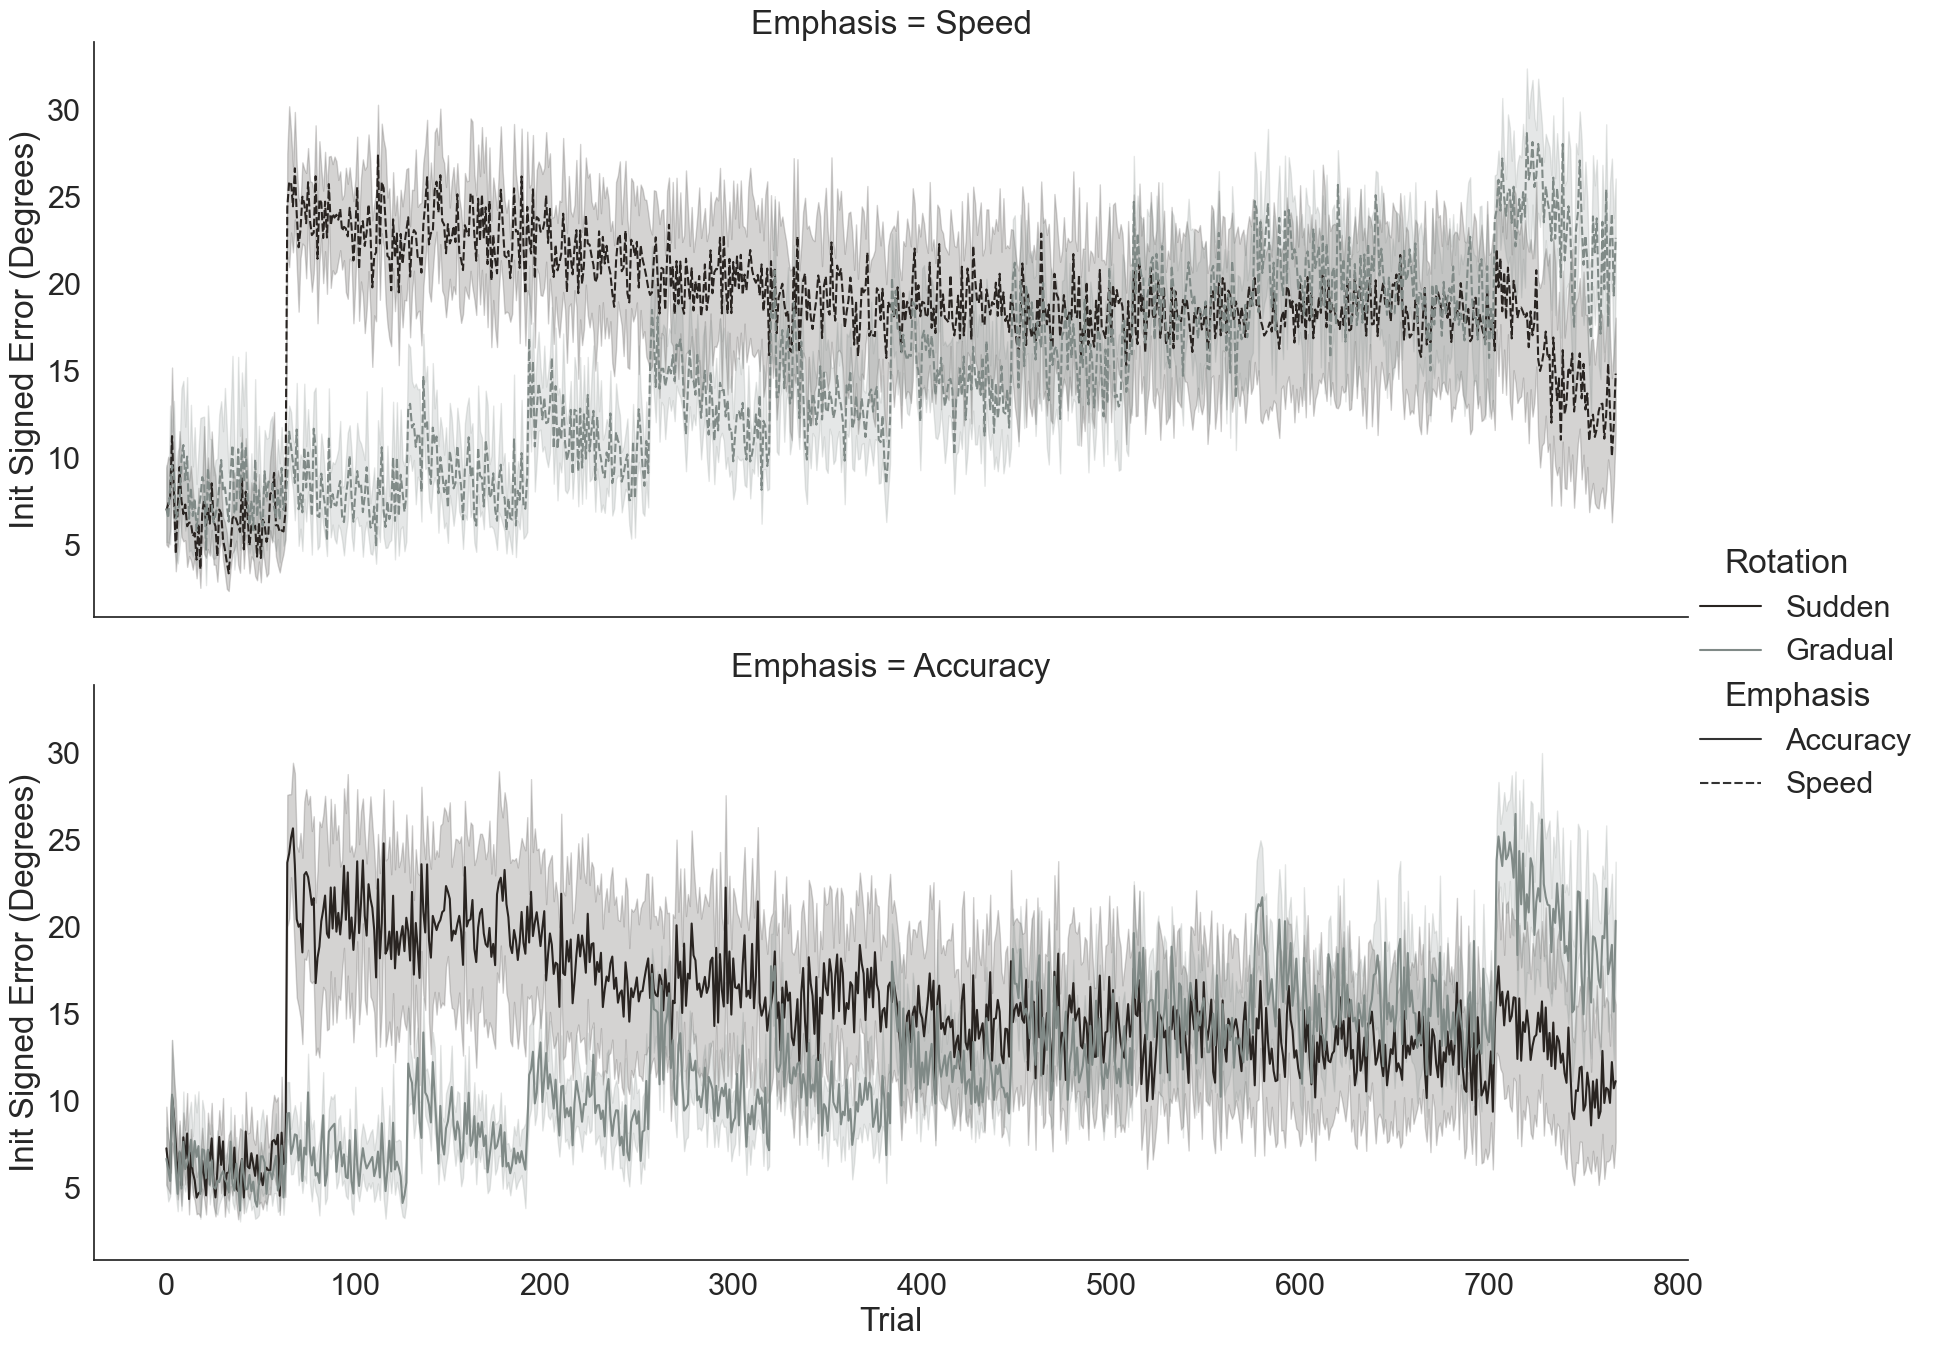

In [8]:
sns.set_context('talk')
sns.set(font_scale = 2)
sns.set_style('white')
colors = [ '#292421', '#808A87']
sns.set_palette(sns.color_palette(colors))

g = sns.relplot(x = 'Trial', y = 'avg errors degrees', hue = 'Rotation', row = 'Emphasis', style='Emphasis', 
                 style_order=['Accuracy', 'Speed'], hue_order=['Sudden', 'Gradual'], row_order=['Speed', 'Accuracy'],
            data = df, height = 7, aspect = 2.5, kind = 'line')
g.set_axis_labels('Trial', 'Init Signed Error (Degrees)')


In [99]:
df_learn = df.loc[((df['Block'] > 0) & (df['Block'] < 11))]
df_learn.to_csv('df_learn.csv', index = False)

p_id  Trial  Block Rotation  Emphasis  init signed error  \
64        0     64      1   Sudden     Speed           1.753594   
65        0     65      1   Sudden     Speed           2.041179   
66        0     66      1   Sudden     Speed           0.902901   
67        0     67      1   Sudden     Speed           2.159052   
68        0     68      1   Sudden     Speed           0.220566   
...     ...    ...    ...      ...       ...                ...   
46011    59    699     10  Gradual  Accuracy           0.002393   
46012    59    700     10  Gradual  Accuracy           0.245410   
46013    59    701     10  Gradual  Accuracy           0.069254   
46014    59    702     10  Gradual  Accuracy          -0.001036   
46015    59    703     10  Gradual  Accuracy           0.243168   

       init signed error degrees  signed avg errors  \
64                    100.473528           0.332945   
65                    116.950952           0.660218   
66                     51.732439           0.438751   
67                    123.704559           0.422749   
68                     12.637477           0.586940   
...                          ...                ...   
46011                   0.137127           0.285975   
46012                  14.060975           0.258337   
46013                   3.967951           0.363400   
46014                  -0.059338           0.209472   
46015                  13.932494           0.238496   

       signed avg errors degrees  avg errors  avg errors degrees  
64                     19.076328    0.332945           19.076328  
65                     37.827702    0.660218           37.827702  
66                     25.138554    0.438751           25.138554  
67                     24.221733    0.422749           24.221733  
68                     33.629189    0.586940           33.629189  
...                          ...         ...                 ...  
46011                  16.385177    0.285975           16.385177  
46012                  14.801626    0.258337           14.801626  
46013                  20.821281    0.363400           20.821281  
46014                  12.001863    0.209472           12.001863  
46015                  13.664828    0.238496           13.664828  

[38400 rows x 11 columns]

In [9]:
def comp_init_ang_error(traj, proportion=0.1, signed = True):
    a, b = traj[:, 0]/np.abs(traj[-1, 0]), traj[:, 1]/np.abs(traj[-1, 1])
    cutoff_dist = proportion

    try:
        for cutoff_point in zip(a, b):
            euclid_dist = np.sqrt(cutoff_point[0]**2 + cutoff_point[1]**2)
            if euclid_dist > cutoff_dist:
                break
    except:
        return np.NaN
    try:
        end_point = traj[-1]
        v1 = end_point - np.array([0, 0])
        v2 = np.array(cutoff_point) - np.array([0, 0])

        dotprod = np.dot(v1, v2)
        v1_magnitudes = np.linalg.norm(v1)
        v2_magnitudes = np.linalg.norm(v2)
        crossprod = np.cross(v1, v2)
        if crossprod < 0:
            sign = -1
        else:
            sign = 1
        if not signed:
            sign = 1
        return sign*np.arccos(dotprod / (v1_magnitudes * v2_magnitudes))
    except:
        return np.NaN

In [10]:
# df_relearn = pd.read_csv('all_trajectories.csv')
errors = []
for traj in cursor_trajectory:
    # print(traj)
    errors.append(comp_init_ang_error(traj))


df['init signed errors'] = -np.ravel(errors)
df['init signed errors degrees'] = df['init signed errors']*180/np.pi


errors = []
for traj in cursor_trajectory:
    # print(traj)
    errors.append(comp_init_ang_error(traj, signed=False))


df['init errors'] = np.ravel(errors)
df['init errors degrees'] = df['init errors']*180/np.pi


C:\Users\tejas\AppData\Local\Temp\ipykernel_19316\1788316581.py:27: RuntimeWarning: invalid value encountered in arccos
  return sign*np.arccos(dotprod / (v1_magnitudes * v2_magnitudes))
C:\Users\tejas\AppData\Local\Temp\ipykernel_19316\1788316581.py:27: RuntimeWarning: invalid value encountered in arccos
  return sign*np.arccos(dotprod / (v1_magnitudes * v2_magnitudes))


In [11]:
#Fill missing values
# Replace gaps forward from the previous valid value in: 'init signed errors', 'init signed errors degrees' and 2 other columns
df = df.fillna({'init signed errors': df['init signed errors'].ffill(), 'init signed errors degrees': df['init signed errors degrees'].ffill(), 'init errors': df['init errors'].ffill(), 'init errors degrees': df['init errors degrees'].ffill()})
df.to_csv('df_allphases_initerror.csv', index = False)

In [21]:
df['avg signed errors'] = df['avg errors']
df['avg signed errors degrees'] = df['avg errors degrees']

df.loc[df['init signed errors'] < 0, 'avg signed errors'] = -df.loc[df['init signed errors'] < 0, 'avg errors']
df.loc[df['init signed errors'] < 0, 'avg signed errors degrees'] = -df.loc[df['init signed errors'] < 0, 'avg errors degrees']



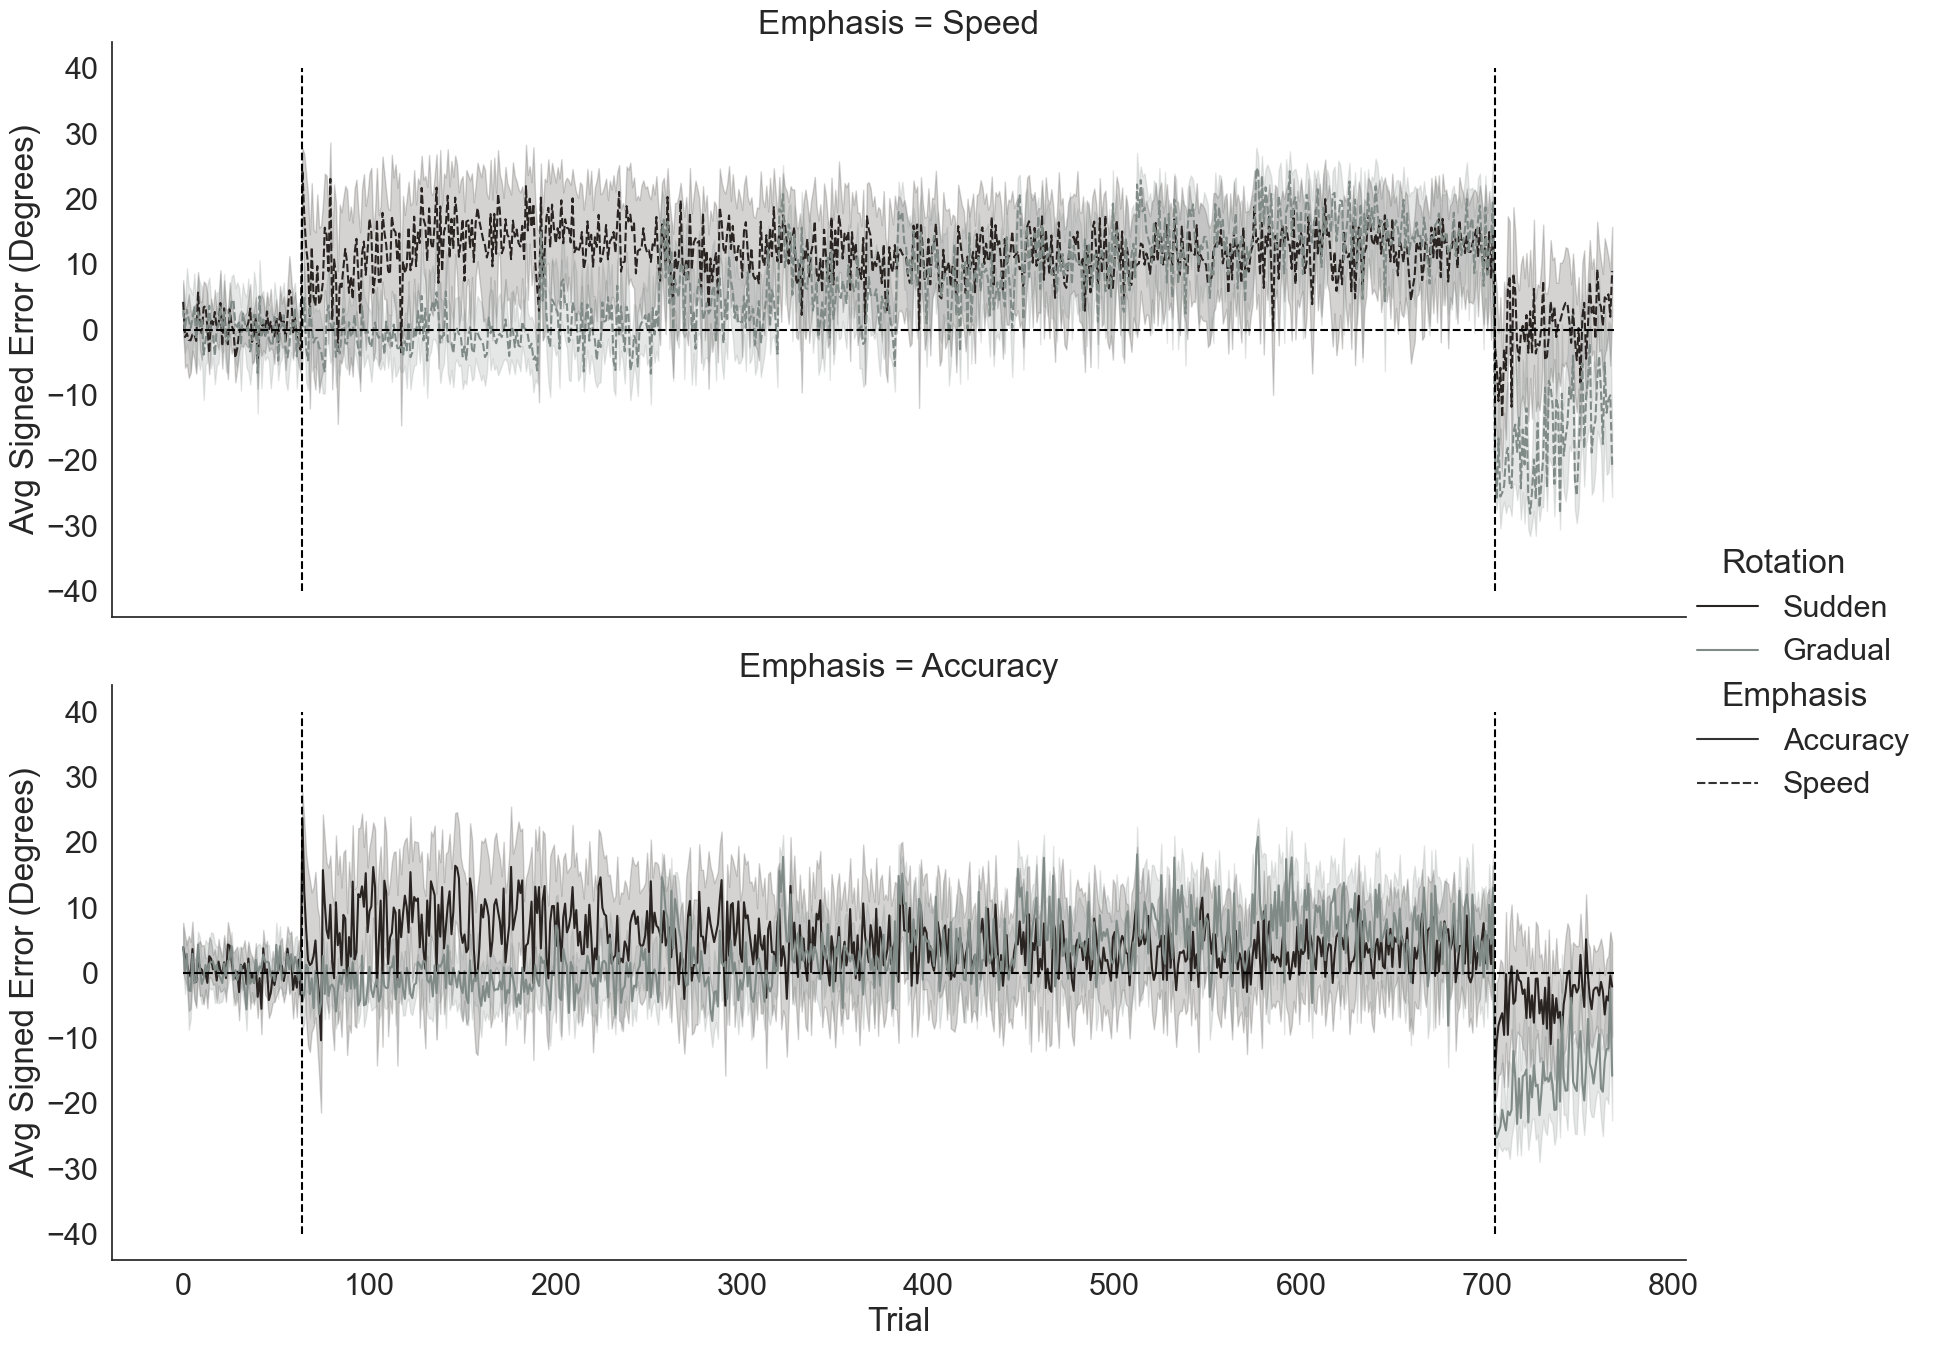

In [22]:
sns.set_context('talk')
sns.set(font_scale = 2)
sns.set_style('white')
colors = [ '#292421', '#808A87']
sns.set_palette(sns.color_palette(colors))

g = sns.relplot(x = 'Trial', y = 'avg signed errors degrees', hue = 'Rotation', row = 'Emphasis', style='Emphasis', 
                 style_order=['Accuracy', 'Speed'], hue_order=['Sudden', 'Gradual'], row_order=['Speed', 'Accuracy'],
            data = df, height = 7, aspect = 2.5, kind = 'line')
g.set_axis_labels('Trial', 'Avg Signed Error (Degrees)')

for ax in g.axes.ravel():
    ax.vlines(x = 64, ymax=40, ymin = -40, color = 'black', linestyles = '--')
    ax.vlines(x = 64*11, ymax=40, ymin = -40, color = 'black', linestyles = '--')

    ax.hlines(y=0, xmin = 0, xmax = 768, color = 'black', linestyles = '--')

In [24]:
df.to_csv('df_allphases_errors.csv', index = False)

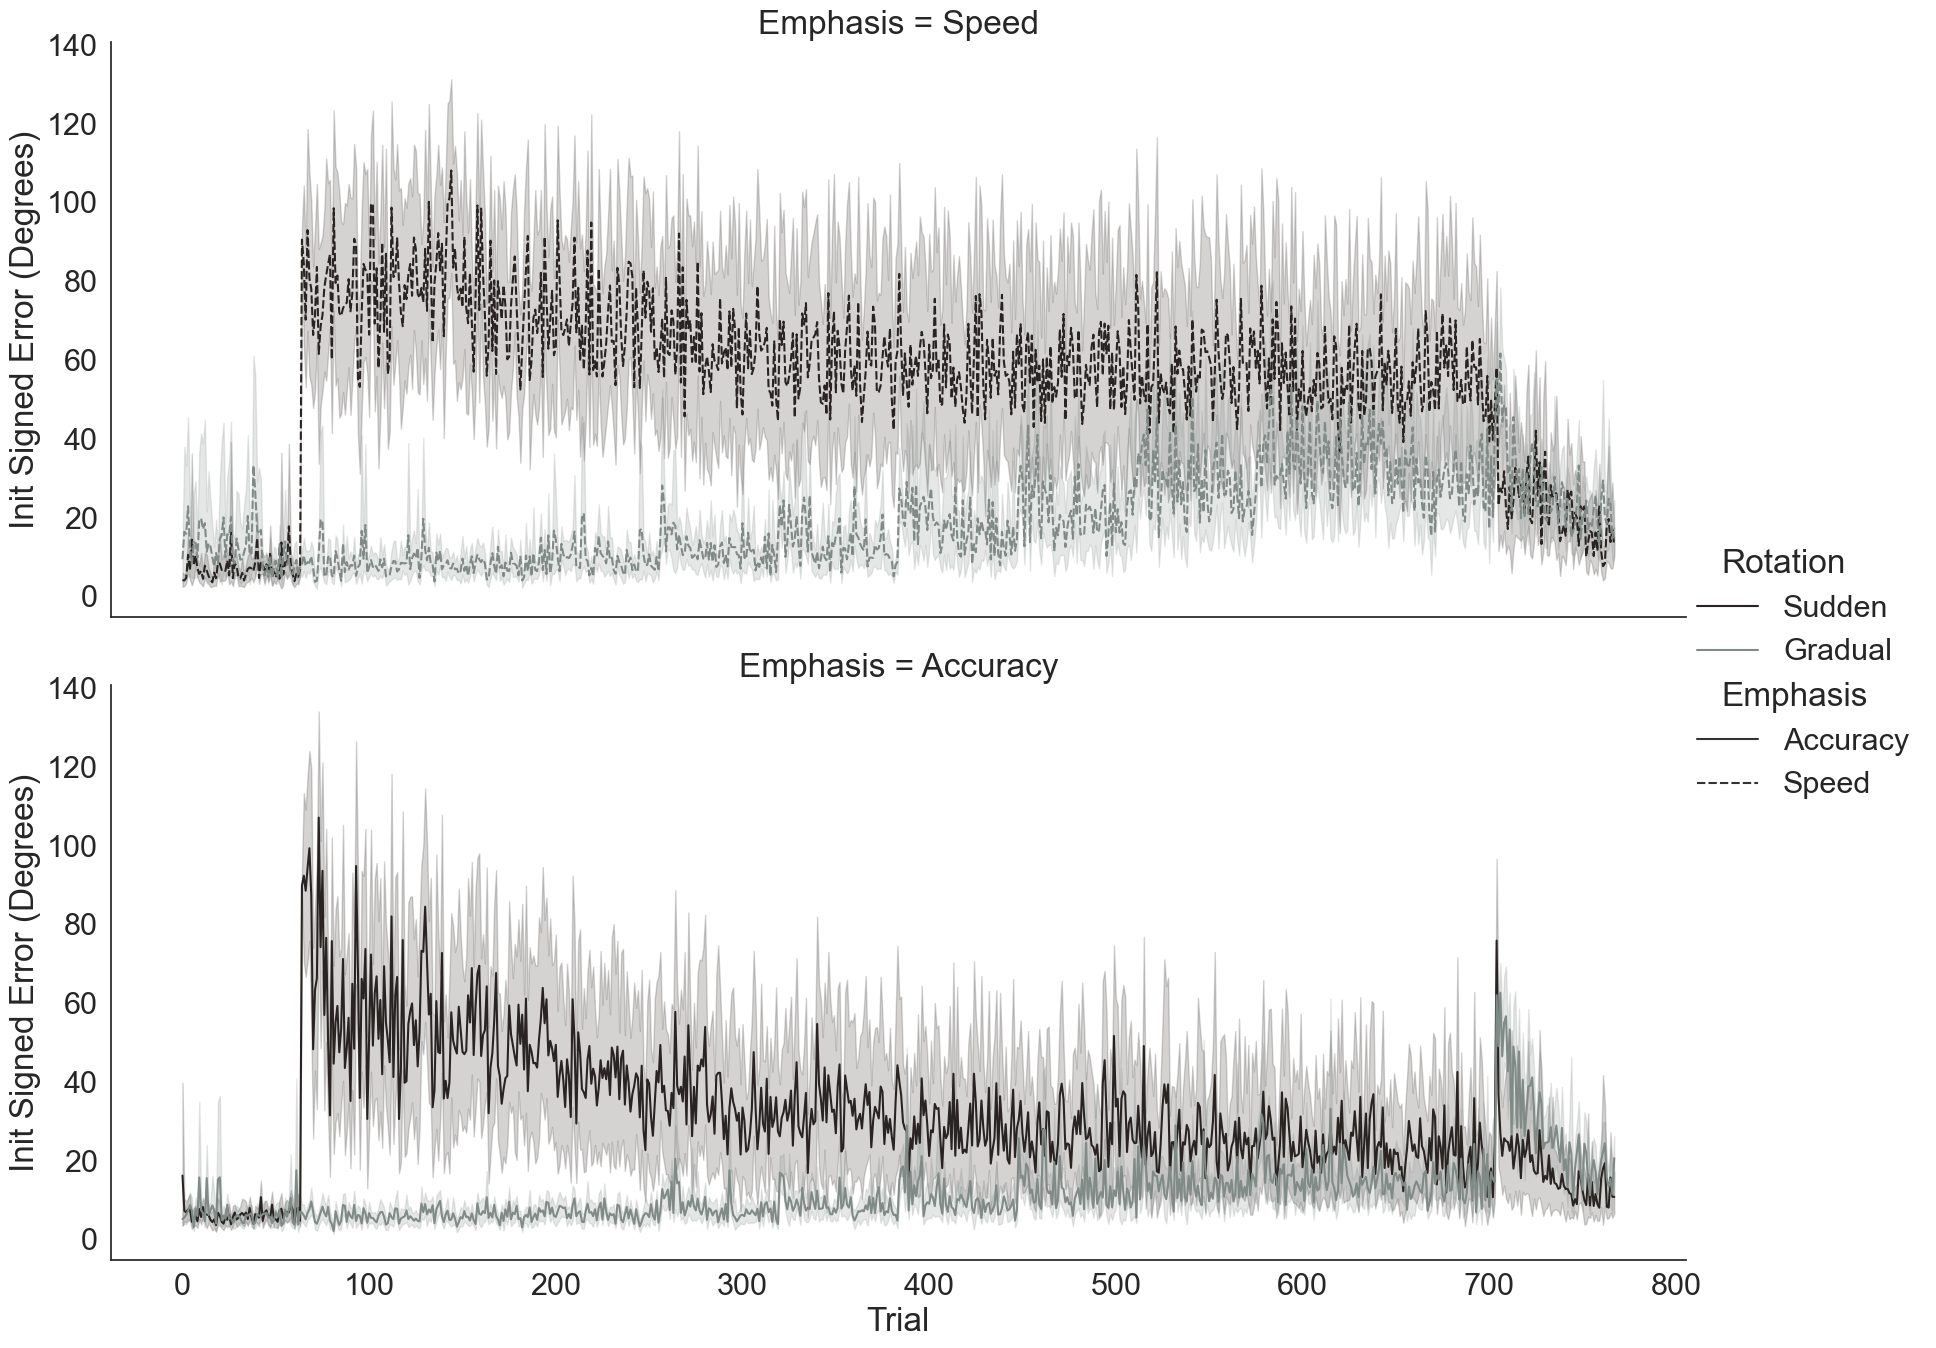

In [66]:
sns.set_context('talk')
sns.set(font_scale = 2)
sns.set_style('white')
colors = [ '#292421', '#808A87']
sns.set_palette(sns.color_palette(colors))

g = sns.relplot(x = 'Trial', y = 'init errors degrees', hue = 'Rotation', row = 'Emphasis', style='Emphasis', 
                 style_order=['Accuracy', 'Speed'], hue_order=['Sudden', 'Gradual'], row_order=['Speed', 'Accuracy'],
            data = df, height = 7, aspect = 2.5, kind = 'line')
g.set_axis_labels('Trial', 'Init Signed Error (Degrees)')


In [67]:
df.to_csv('df_allphases_initerror.csv', index = False)

p_id  Trial  Block Rotation  Emphasis  init signed errors  \
0         0      0      0   Sudden     Speed            0.140367   
1         0      1      0   Sudden     Speed           -0.037216   
2         0      2      0   Sudden     Speed           -0.048070   
3         0      3      0   Sudden     Speed           -0.059439   
4         0      4      0   Sudden     Speed           -0.034114   
...     ...    ...    ...      ...       ...                 ...   
46075    59    763     11  Gradual  Accuracy           -0.363901   
46076    59    764     11  Gradual  Accuracy           -0.412636   
46077    59    765     11  Gradual  Accuracy           -0.800991   
46078    59    766     11  Gradual  Accuracy           -0.491390   
46079    59    767     11  Gradual  Accuracy           -0.411225   

       init signed errors degrees  init errors  init errors degrees  
0                        8.042440     0.140367             8.042440  
1                       -2.132311     0.037216             2.132311  
2                       -2.754213     0.048070             2.754213  
3                       -3.405619     0.059439             3.405619  
4                       -1.954605     0.034114             1.954605  
...                           ...          ...                  ...  
46075                  -20.850013     0.363901            20.850013  
46076                  -23.642282     0.412636            23.642282  
46077                  -45.893385     0.800991            45.893385  
46078                  -28.154572     0.491390            28.154572  
46079                  -23.561479     0.411225            23.561479  

[46080 rows x 9 columns]

In [5]:
df = pd.read_csv('df_allphases_initerror.csv')
df['init washout signed errors'] = df['init errors']
df.loc[df['Block'] == 11, 'init washout signed errors'] = -df.loc[df['Block'] == 11, 'init washout signed errors']
df.to_csv('df_allphases_initerror.csv', index = False)

In [311]:
smoothed = []
for participant in df.p_id.unique():
    for block in range(12):
        temp = df.loc[((df['p_id'] == participant) & (df['Block'] == block)), 'avg errors'].values
        df.loc[((df['p_id'] == participant) & (df['Block'] == block)), 'avg errors'] = np.nan_to_num(temp, nan = np.nanmedian(temp))
        smoothed.append(gaussian_filter(df.loc[((df['p_id'] == participant) & (df['Block'] == block)), 'avg errors'].values, sigma=2))

smoothed = np.ravel(smoothed)

df['smoothed avg error'] = smoothed
df['smoothed avg error degrees'] = df['smoothed avg error']*180/np.pi
# df = df.drop('cursor trajectory', axis = 1)

In [313]:
def clean_data(df):
    # Replace gaps forward from the previous valid value in: 'avg errors', 'avg errors degrees' and 2 other columns
    df = df.fillna({'avg errors': df['smoothed avg error'].ffill(), 'avg errors degrees': df['avg errors degrees'].ffill(), 'smoothed avg error': df['smoothed avg error'].ffill(), 'smoothed avg error degrees': df['smoothed avg error degrees'].ffill()})
    return df

df_clean = clean_data(df.copy())
df_clean.head()

p_id  Trial  Block Rotation Emphasis  avg errors  avg errors degrees  \
0     0      0      0   Sudden    Speed    0.087757            0.087757   
1     0      1      0   Sudden    Speed    0.109257            0.109257   
2     0      2      0   Sudden    Speed    0.229315            0.229315   
3     0      3      0   Sudden    Speed    0.044903            0.229315   
4     0      4      0   Sudden    Speed    0.041478            0.041478   

   smoothed avg error  smoothed avg error degrees  
0            0.114167                    6.541259  
1            0.111866                    6.409433  
2            0.104513                    5.988174  
3            0.091834                    5.261720  
4            0.078135                    4.476785

In [328]:
df = df.drop('cursor trajectory', axis = 1)

In [330]:
df.to_csv('df_allphases.csv')

In [77]:
df

p_id  Trial  Block Rotation  Emphasis  init signed error  \
0         0      0      0   Sudden     Speed           0.140367   
1         0      1      0   Sudden     Speed          -0.037216   
2         0      2      0   Sudden     Speed          -0.048070   
3         0      3      0   Sudden     Speed          -0.059439   
4         0      4      0   Sudden     Speed          -0.034114   
...     ...    ...    ...      ...       ...                ...   
46075    59    763     11  Gradual  Accuracy          -0.363901   
46076    59    764     11  Gradual  Accuracy          -0.412636   
46077    59    765     11  Gradual  Accuracy          -0.800991   
46078    59    766     11  Gradual  Accuracy          -0.491390   
46079    59    767     11  Gradual  Accuracy          -0.411225   

       init signed error degrees  signed avg errors  signed avg errors degrees  
0                       8.042440          -0.085617                  -4.905479  
1                      -2.132311           0.037203                   2.131555  
2                      -2.754213           0.081677                   4.679736  
3                      -3.405619           0.114367                   6.552725  
4                      -1.954605           0.141878                   8.129014  
...                          ...                ...                        ...  
46075                 -20.850013          -0.022899                  -1.311991  
46076                 -23.642282           0.052473                   3.006491  
46077                 -45.893385           0.036415                   2.086450  
46078                 -28.154572           0.059765                   3.424297  
46079                 -23.561479           0.090272                   5.172190  

[46080 rows x 9 columns]

In [334]:
df_learn = df.loc[df['Block'] < 11].reset_index().drop('index', axis = 1)
df_washout = df.loc[df['Block'] == 11].reset_index().drop('index', axis = 1)
df_washout['Trial'] = np.tile(np.arange(64), 60)
df_learn.to_csv('df_learn.csv')
df_washout.to_csv('df_washout.csv')

In [50]:
# df_allphases = pd.read_csv('df_allphases.csv')

Unnamed: 0  p_id  Trial  Block Rotation  Emphasis  init errors  \
0               0     0      0      0   Sudden     Speed     0.140367   
1               1     0      1      0   Sudden     Speed     0.037216   
2               2     0      2      0   Sudden     Speed     0.048070   
3               3     0      3      0   Sudden     Speed     0.059439   
4               4     0      4      0   Sudden     Speed     0.034114   
...           ...   ...    ...    ...      ...       ...          ...   
46075       46075    59    763     11  Gradual  Accuracy    -0.363901   
46076       46076    59    764     11  Gradual  Accuracy    -0.412636   
46077       46077    59    765     11  Gradual  Accuracy    -0.800991   
46078       46078    59    766     11  Gradual  Accuracy    -0.491390   
46079       46079    59    767     11  Gradual  Accuracy    -0.411225   

       init errors degrees  
0                 8.042440  
1                 2.132311  
2                 2.754213  
3                 3.405619  
4                 1.954605  
...                    ...  
46075           -20.850013  
46076           -23.642282  
46077           -45.893385  
46078           -28.154572  
46079           -23.561479  

[46080 rows x 8 columns]

In [45]:
# df['avg errors smooth'] = 
df_learn_signed = pd.read_csv('df_learn_signed.csv')
smoothed = []
for participant in range(60):
    for block in range(1, 11):
        smoothed.append(gaussian_filter(df_learn_signed.loc[((df_learn_signed['p_id'] == participant) & (df_learn_signed['Block'] == block)), 'init signed error'].values, sigma = 2))
df_learn_signed['init signed smooth'] = np.ravel(smoothed)

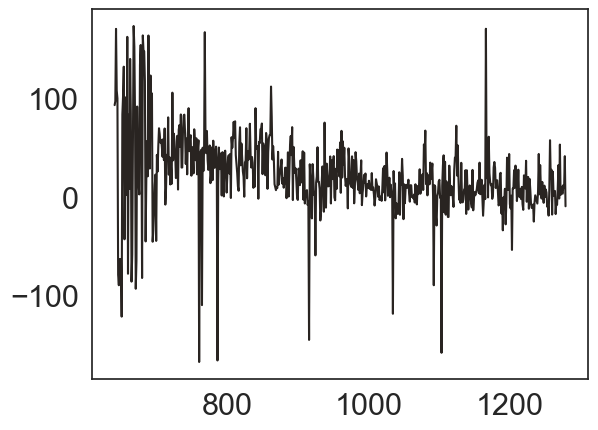

In [41]:
plt.plot(df_learn_signed.loc[640:640*2, 'init signed error degrees'])

In [47]:
df_learn_signed_smooth = df_learn_signed.copy()
df_learn_signed_smooth.to_csv('df_laern_signed_smooth.csv', index = False)

In [7]:
df_learn_signed = pd.read_csv('df_learn_signed.csv')
# df_learn_signed

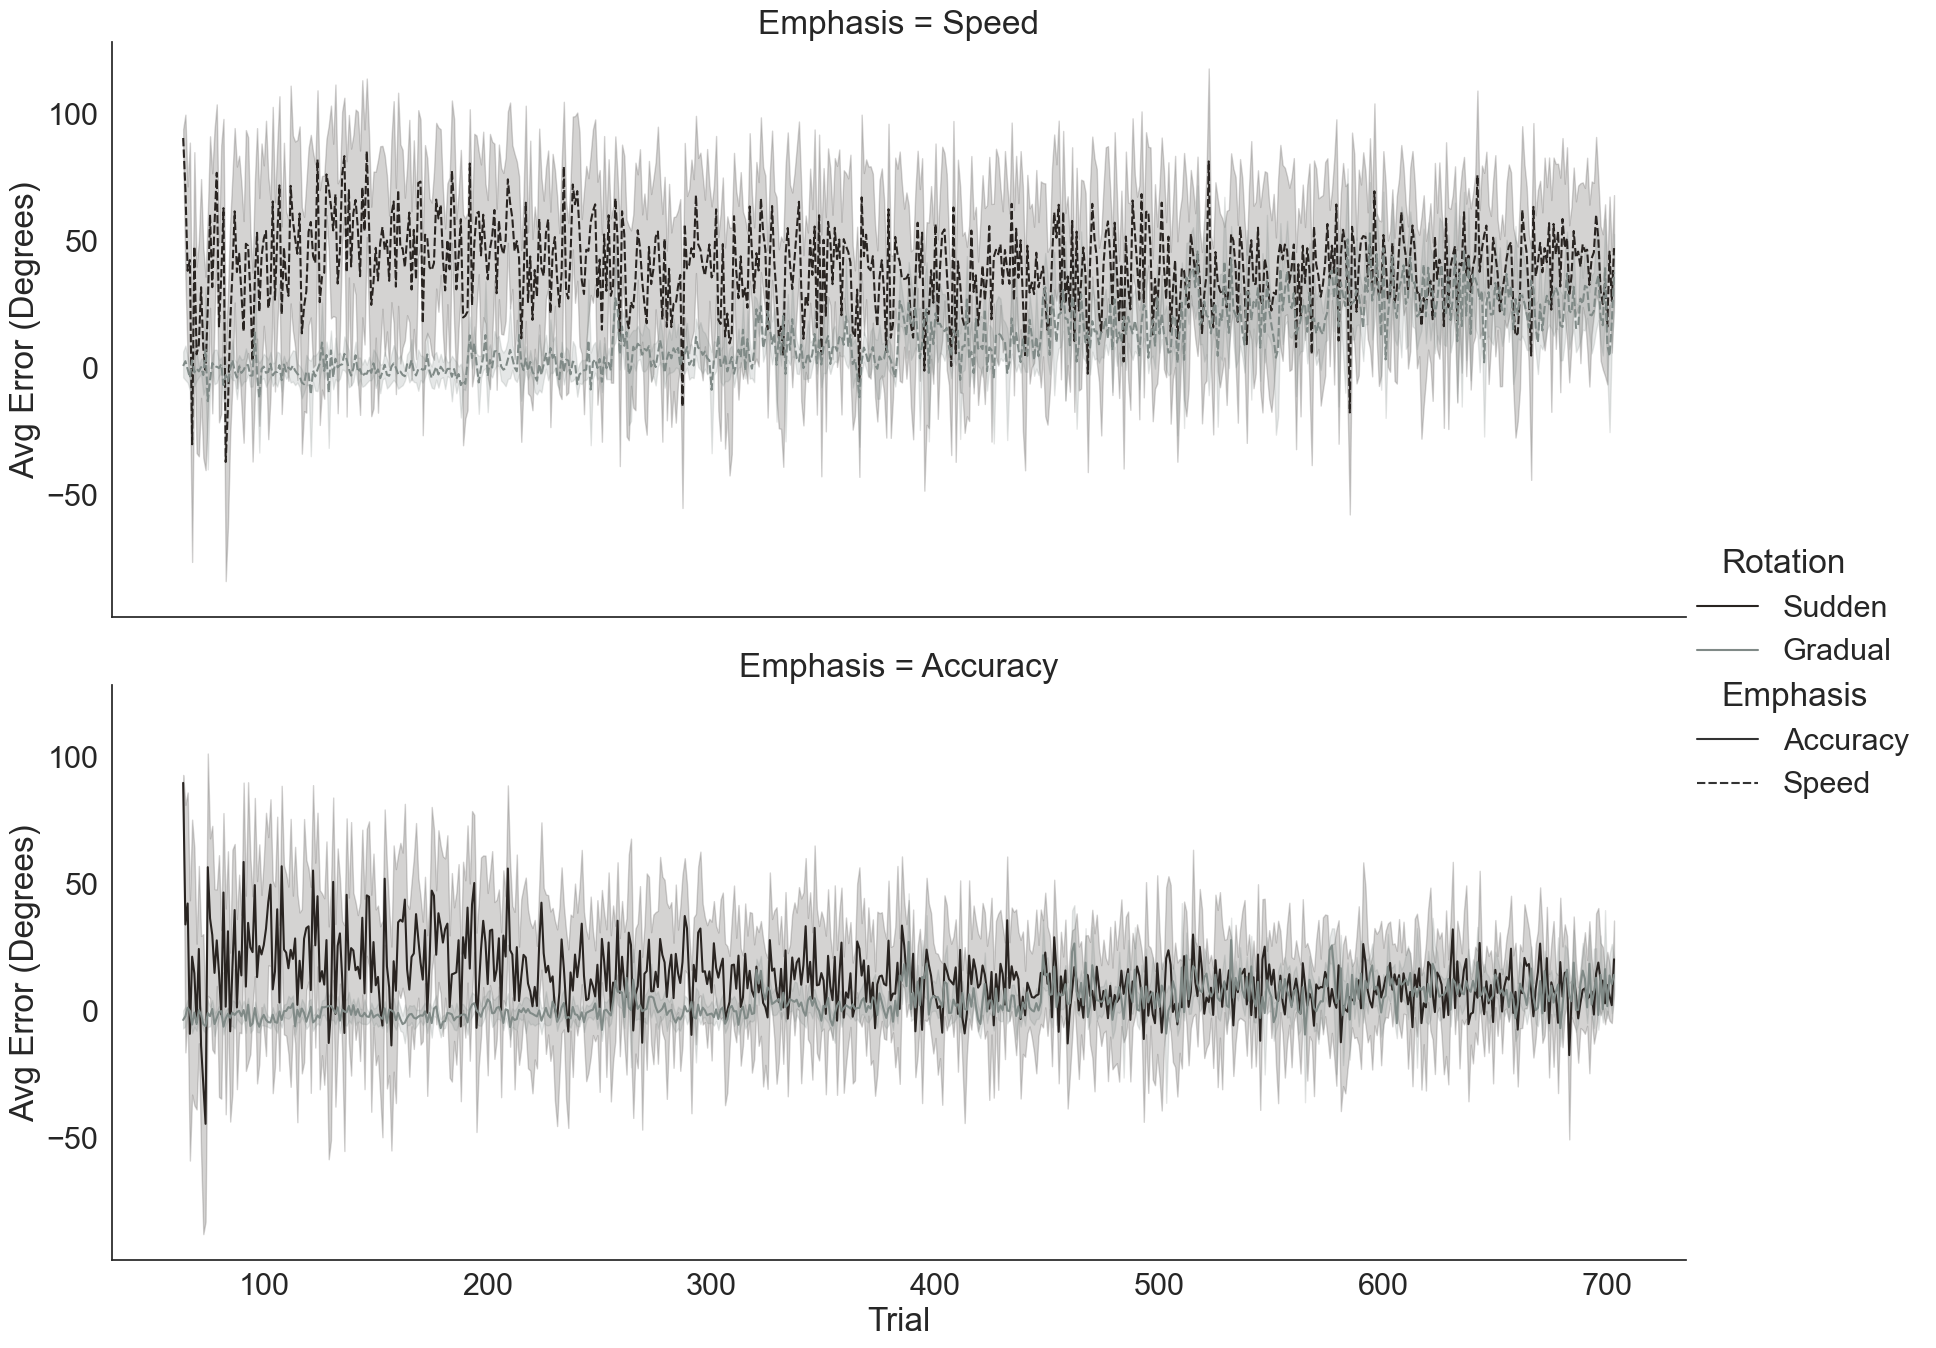

In [48]:
sns.set_context('talk')
sns.set(font_scale = 2)
sns.set_style('white')
colors = [ '#292421', '#808A87']
sns.set_palette(sns.color_palette(colors))

g = sns.relplot(x = 'Trial', y = 'init signed error degrees', hue = 'Rotation', row = 'Emphasis', style='Emphasis', 
                 style_order=['Accuracy', 'Speed'], hue_order=['Sudden', 'Gradual'], row_order=['Speed', 'Accuracy'],
            data = df_learn_signed, height = 7, aspect = 2.5, kind = 'line')
g.set_axis_labels('Trial', 'Avg Error (Degrees)')

# draw lines:
# for ax in g.axes.ravel():
#     ax.vlines(x = 64, ymax=100, ymin = -100, color = 'black', linestyles = '--')
#     ax.vlines(x = 64*8, ymax=100, ymin = -100, color = 'black', linestyles = '--')
#     ax.vlines(x = 64*9, ymax=100, ymin = -100, color = 'black', linestyles = '--')

#     ax.hlines(y=0, xmin = 0, xmax = 640, color = 'black', linestyles = '--')

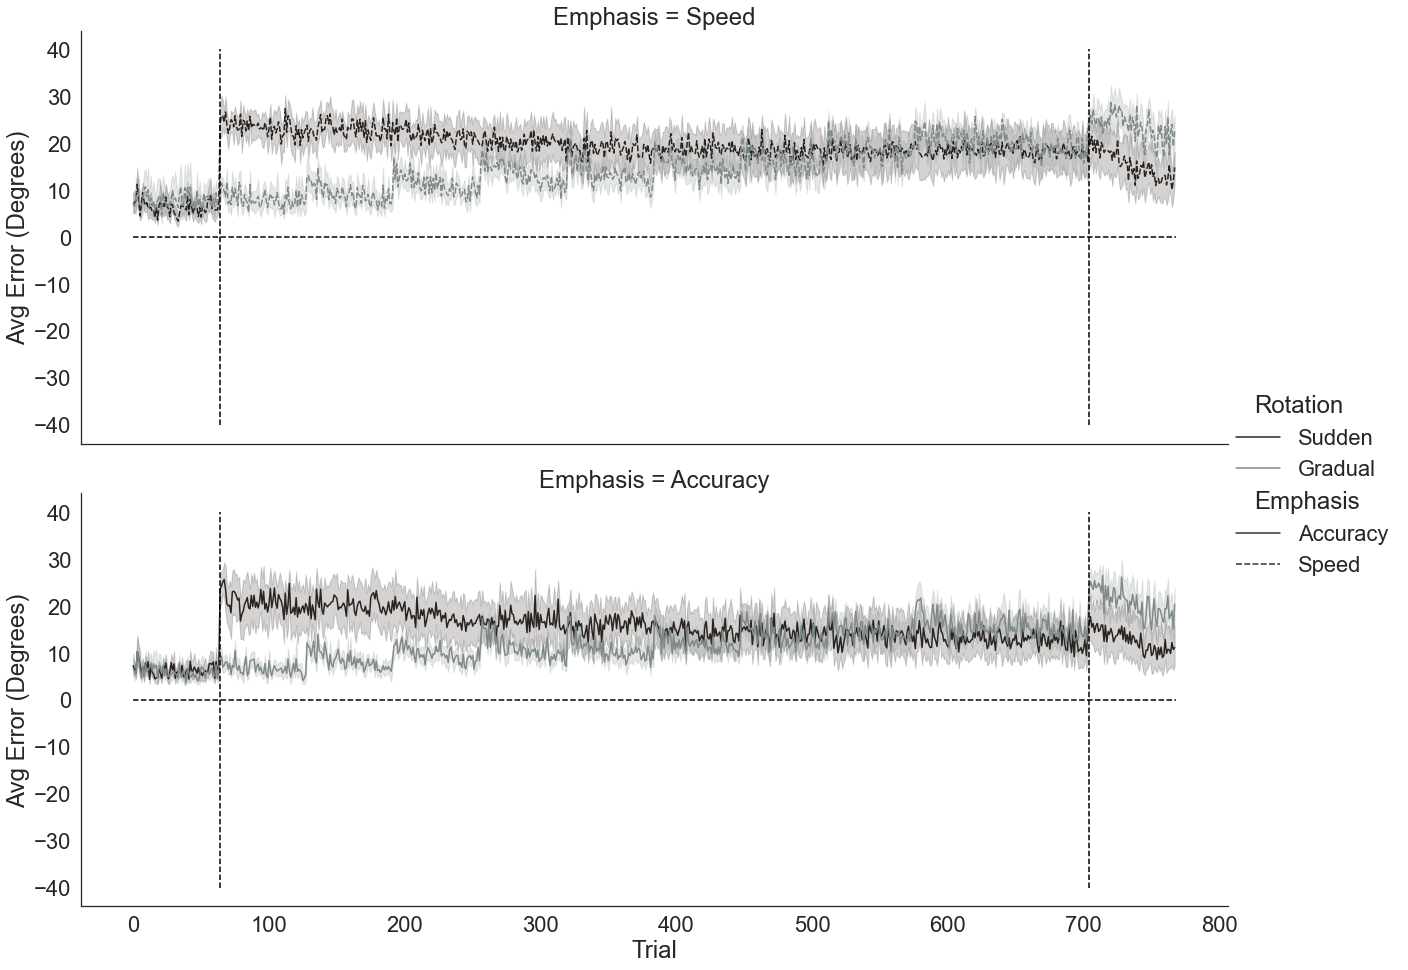

In [100]:
sns.set_context('talk')
sns.set(font_scale = 2)
sns.set_style('white')
colors = [ '#292421', '#808A87']
sns.set_palette(sns.color_palette(colors))

g = sns.relplot(x = 'Trial', y = 'avg errors degrees', hue = 'Rotation', row = 'Emphasis', style='Emphasis', 
                 style_order=['Accuracy', 'Speed'], hue_order=['Sudden', 'Gradual'], row_order=['Speed', 'Accuracy'],
            data = df, height = 7, aspect = 2.5, kind = 'line')
g.set_axis_labels('Trial', 'Avg Error (Degrees)')

# draw lines:
for ax in g.axes.ravel():
    ax.vlines(x = 64, ymax=40, ymin = -40, color = 'black', linestyles = '--')
    ax.vlines(x = 64*11, ymax=40, ymin = -40, color = 'black', linestyles = '--')

    ax.hlines(y=0, xmin = 0, xmax = 768, color = 'black', linestyles = '--')

In [79]:
df = df.drop('cursor trajectory', axis = 1)
df.to_csv('df_allphases.csv')


In [86]:
df_learn = df.loc[((df['Block'] > 0) & (df['Block'] < 11))].reset_index().drop('index', axis = 1)
df_learn.to_csv('df_learn.csv')

In [91]:
df_blockwise = pd.read_csv('df_blockwise.csv')

In [ ]:
df_allphases = pd.read_csv('df_allphases.csv')

In [103]:
df_learnwashout = df.loc[((df['Block'] > 0))].reset_index().drop('index', axis = 1)


In [105]:
df_learnwashout.to_csv('df_learnwashout.csv', index = False)

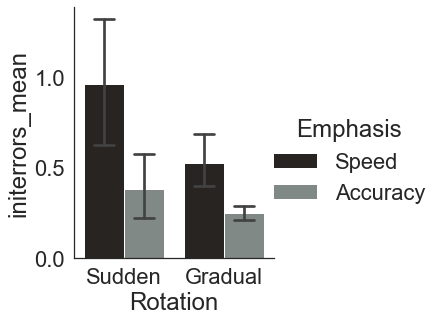

In [95]:
sns.catplot(y = 'initerrors_mean', x = 'Rotation', hue = 'Emphasis', 
            data = df_blockwise.loc[((df_blockwise['Block'] == 10))], 
            kind = 'bar', capsize = 0.2)

In [ ]:
df_allphases_blockwise['difference'] = df_allphases_blockwise['initerrors_mean'].diff(periods= 2)

In [ ]:
g = sns.catplot(y = 'difference', x = 'Rotation', hue = 'Emphasis', 
            data = df_allphases_blockwise.loc[((df_allphases_blockwise['block no'] == 8))], 
            kind = 'bar', capsize = 0.2)
g.set_ylabels('Error Difference \n Relearning - Learning')


In [3]:
num_participants = 60
num_blocks = 12
num_trials = 64
participants = np.arange(1000, 1000 + num_participants)
blocks = np.arange(0, num_blocks)
cursor_trajectory = []
for participant in participants:
    for block in blocks:
        temp =  scipy.io.loadmat(f'Data/data{participant}/actual_trajectories/trajectories{block}.mat')
        for trial in np.arange(num_trials):
            cursor_trajectory.append(np.array((temp['x'].T[trial][0], temp['y'].T[trial][0])).T.reshape(temp['x'].T[trial][0].shape[1], 2))


def comp_init_ang_error(traj, proportion=0.1):
    a, b = traj[:, 0]/np.abs(traj[-1, 0]), traj[:, 1]/np.abs(traj[-1, 1])
    cutoff_dist = proportion

    try:
        for cutoff_point in zip(a, b):
            euclid_dist = np.sqrt(cutoff_point[0]**2 + cutoff_point[1]**2)
            if euclid_dist > cutoff_dist:
                break
    except:
        return np.NaN
    try:
        end_point = traj[-1]
        v1 = end_point - np.array([0, 0])
        v2 = np.array(cutoff_point) - np.array([0, 0])

        dotprod = np.dot(v1, v2)
        v1_magnitudes = np.linalg.norm(v1)
        v2_magnitudes = np.linalg.norm(v2)
        cross = np.cross(v1, v2)
        if cross > 0:
            sign = -1
        else:
            sign = 1
        return sign*np.arccos(dotprod / (v1_magnitudes * v2_magnitudes))
    except:
        return np.NaN

In [4]:
init_signed_error = []
for traj in cursor_trajectory:
    init_signed_error.append(comp_init_ang_error(traj))

C:\Users\tejas\AppData\Local\Temp\ipykernel_13764\1865050589.py:38: RuntimeWarning: invalid value encountered in arccos
  return sign*np.arccos(dotprod / (v1_magnitudes * v2_magnitudes))


In [9]:
df = pd.DataFrame({'p_id' : np.repeat(np.arange(num_participants), num_blocks*num_trials),
                    'Trial': np.tile(np.arange(768), 60),
                    'Block': np.tile(np.repeat(np.arange(12), 64), 60), 
                    'Rotation': np.tile(np.repeat(np.array(['Sudden', 'Sudden', 'Gradual', 'Gradual']), 768), 15),
                    'Emphasis': np.tile(np.repeat(np.array(['Speed', 'Accuracy']), 768), 30),
                    'init signed error': np.array(init_signed_error),
                    'init signed error degrees': np.array(init_signed_error)*180/np.pi,

                   
})

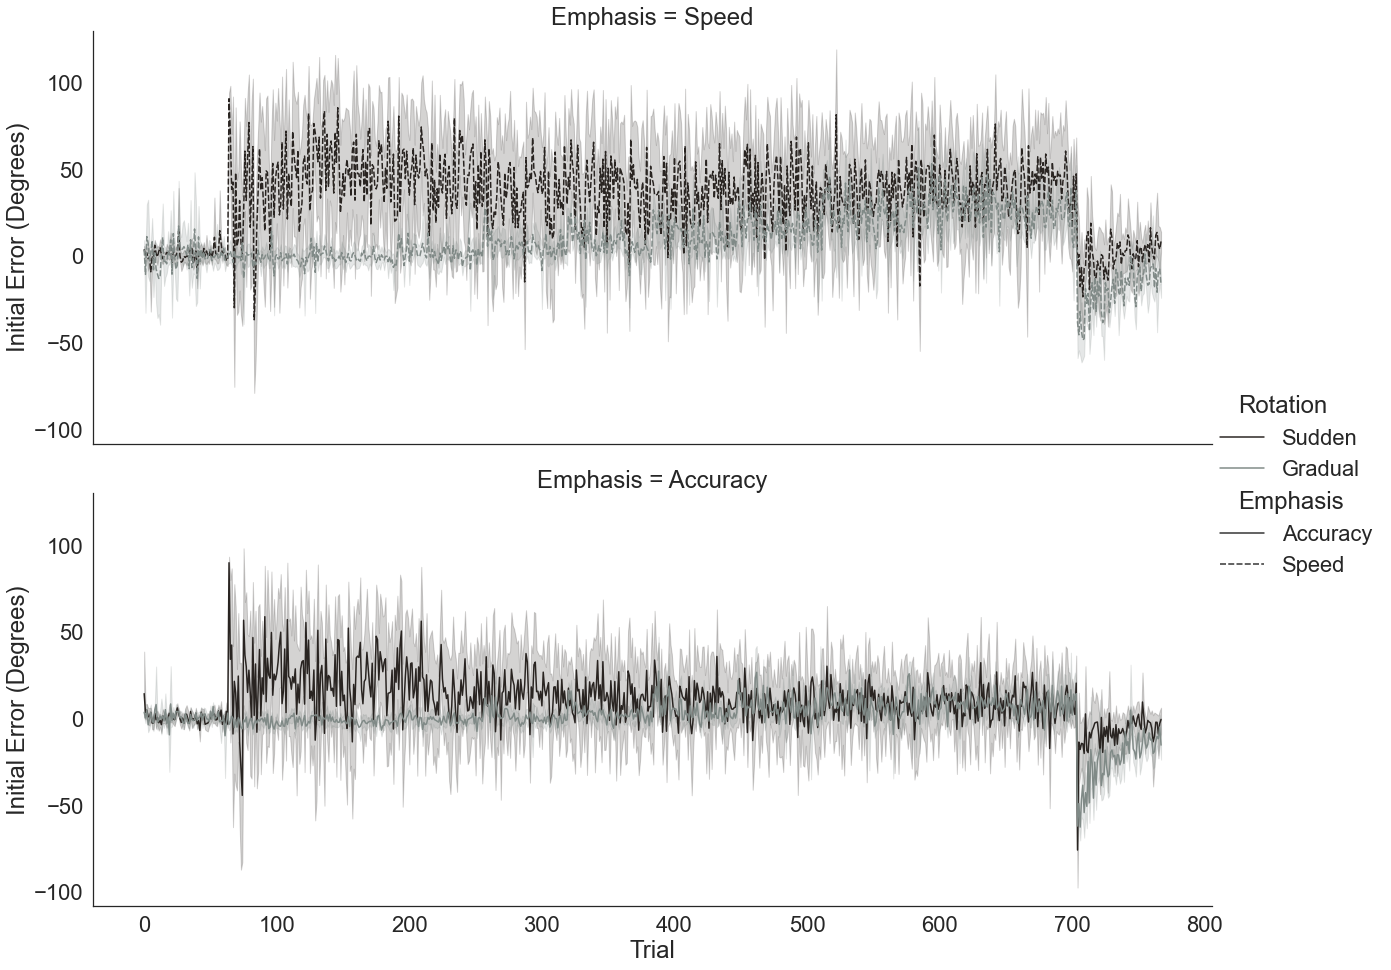

In [31]:
sns.set_context('talk')
sns.set(font_scale = 2)
sns.set_style('white')
colors = [ '#292421', '#808A87']
sns.set_palette(sns.color_palette(colors))

g = sns.relplot(x = 'Trial', y = 'init signed error degrees', hue = 'Rotation', row = 'Emphasis', style='Emphasis', 
                 style_order=['Accuracy', 'Speed'], hue_order=['Sudden', 'Gradual'], row_order=['Speed', 'Accuracy'],
            data = df, height = 7, aspect = 2.5, kind = 'line')
g.set_axis_labels('Trial', 'Initial Error (Degrees)')


In [12]:
def blockwise_data(df):
    # Performed 2 aggregations grouped on columns: 'p_id', 'Block' and 2 other columns
    df = df.groupby(['p_id', 'Block', 'Rotation', 'Emphasis']).agg(initsignederror_mean=('init signed error', 'mean'), initsignederrordegrees_mean=('init signed error degrees', 'mean')).reset_index()
    return df

df_blockwise = blockwise_data(df.copy())


In [36]:
np.mean(df_blockwise.loc[((df_blockwise['Rotation'] == 'Sudden') & (df_blockwise['Emphasis'] == 'Speed') & (df_blockwise['Block'] == 11)), 'initsignederrordegrees_mean'])

0.06903372848374924

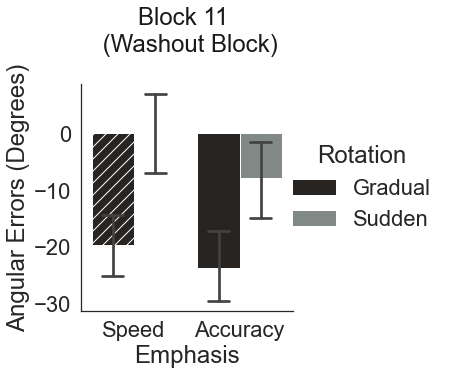

In [38]:
# df_blockwise['initerrors_mean_degrees'] = df_blockwise['initerrors_mean']*180/np.pi
g = sns.catplot(x = 'Emphasis', hue = 'Rotation', y = 'initsignederrordegrees_mean', col = 'Block',
            data = df_blockwise.loc[((df_blockwise['Block']==11))],
            kind = 'bar', capsize = 0.2, hue_order=['Gradual', 'Sudden'] 
            )
x1, x2 = 0, 1
y, h, col = df_blockwise.loc[(df_blockwise['Block'] == 11)]['initsignederrordegrees_mean'].max()-35, 0.02, 'k'
plt.text(0.5, y+h+25, "Block 11 \n (Washout Block)", ha='center', va='bottom', color=col)
# plt.text(0.5, y+h+5, "*", ha='center', va='bottom', color=col)
# plt.axhline(y=y+h+10, xmin=0.25, xmax=0.75, color = 'black')
# plt.text(0, y+h, "*", ha='center', va='bottom', color=col)
# plt.axhline(y=y+h+5, xmin=0.125, xmax=0.375, color = 'black')
# plt.text(1, y+h, "*", ha='center', va='bottom', color=col)
# plt.axhline(y=y+h+5, xmin=0.625, xmax=0.875, color = 'black')

g.set(ylabel='Angular Errors (Degrees)')
g.set(title=None)

# g.set_yl
hatches = ['//', '', '//', '']
for ax in g.axes.flat:
    patches = [patch for patch in ax.patches]
    for i, patch in enumerate(patches):
        patch.set_hatch(hatches[i])


In [21]:
df_learn = df.loc[((df['Block'] > 0) & (df['Block'] < 11))].reset_index().drop('index', axis = 1)
df_learn.to_csv('df_learn_signed.csv') 
#Used data wrangler to fill missing values and resaved it.

In [30]:
df_learn_washout = df.loc[(df['Block'] > 0)].reset_index().drop('index', axis = 1)
df_learn_washout.to_csv('df_learnwashout_signed.csv', index = False)
#Used data wrangler to fill missing values and resaved it.
# df_learn_washout

p_id  Trial  Block Rotation  Emphasis  init signed error  \
0         0     64      1   Sudden     Speed           1.753594   
1         0     65      1   Sudden     Speed           2.041179   
2         0     66      1   Sudden     Speed           0.902901   
3         0     67      1   Sudden     Speed           2.159052   
4         0     68      1   Sudden     Speed           0.220566   
...     ...    ...    ...      ...       ...                ...   
42235    59    763     11  Gradual  Accuracy          -0.363901   
42236    59    764     11  Gradual  Accuracy          -0.412636   
42237    59    765     11  Gradual  Accuracy          -0.800991   
42238    59    766     11  Gradual  Accuracy          -0.491390   
42239    59    767     11  Gradual  Accuracy          -0.411225   

       init signed error degrees  
0                     100.473528  
1                     116.950952  
2                      51.732439  
3                     123.704559  
4                      12.637477  
...                          ...  
42235                 -20.850013  
42236                 -23.642282  
42237                 -45.893385  
42238                 -28.154572  
42239                 -23.561479  

[42240 rows x 7 columns]

# Descriptive and Inferential stats

In [3]:
df = pd.read_csv('df_allphases_initerror.csv')
df_blockwise = pd.read_csv('df_allphases_initerror_blockwise.csv')

Block  p_id Rotation  Emphasis  initsignederrors_mean  \
0        0     0   Sudden     Speed               0.016827   
1        0     1   Sudden  Accuracy               0.092469   
2        0     2  Gradual     Speed               0.004107   
3        0     3  Gradual  Accuracy              -0.014476   
4        0     4   Sudden     Speed               0.063023   
..     ...   ...      ...       ...                    ...   
715     11    55  Gradual  Accuracy              -0.452930   
716     11    56   Sudden     Speed               0.410334   
717     11    57   Sudden  Accuracy              -0.025123   
718     11    58  Gradual     Speed              -0.545583   
719     11    59  Gradual  Accuracy              -0.666505   

     initsignederrorsdegrees_mean  initerrors_mean  initerrorsdegrees_mean  \
0                        0.964139         0.099624                5.708045   
1                        5.298094         0.192104               11.006744   
2                        0.235303         0.107960                6.185674   
3                       -0.829410         0.143178                8.203479   
4                        3.610964         0.165827                9.501191   
..                            ...              ...                     ...   
715                    -25.950958         0.461408               26.436723   
716                     23.510397         0.566188               32.440190   
717                     -1.439428         0.103298                5.918555   
718                    -31.259630         0.612495               35.093358   
719                    -38.187922         0.666505               38.187922   

     initwashoutsignederrors_mean  
0                        0.099624  
1                        0.192104  
2                        0.107960  
3                        0.143178  
4                        0.165827  
..                            ...  
715                     -0.461408  
716                     -0.566188  
717                     -0.103298  
718                     -0.612495  
719                     -0.666505  

[720 rows x 9 columns]

# RT Analyses

In [4]:
num_participants = 60
num_blocks = 12
num_trials = 64
participants = np.arange(1000, 1000 + num_participants)
blocks = np.arange(0, num_blocks)
it = []
mt = []

for participant in participants:
    for block in blocks:
        temp_it =  scipy.io.loadmat(f'Data/data{participant}/initial_time/initial_time{block}.mat')
        temp_mt =  scipy.io.loadmat(f'Data/data{participant}/movement_time/movement_time{block}.mat')

        # for trial in np.arange(num_trials):
        it.append(np.ravel(temp_it['initial_time']))
        mt.append(np.ravel(temp_mt['movement_time']))


In [5]:
df = pd.DataFrame({'p_id' : np.repeat(np.arange(num_participants), num_blocks*num_trials),
                    'Trial': np.tile(np.arange(768), 60),
                    'Block': np.tile(np.repeat(np.arange(12), 64), 60), 
                    'Rotation': np.tile(np.repeat(np.array(['Sudden', 'Sudden', 'Gradual', 'Gradual']), 768), 15),
                    'Emphasis': np.tile(np.repeat(np.array(['Speed', 'Accuracy']), 768), 30),
                    'IT': np.ravel(it),
                    'TT': np.ravel(mt) + np.ravel(it)
                #    'cursor trajectory': np.array(cursor_trajectory, dtype = object)
})

In [6]:
df_blockwise = df.groupby(['p_id', 'Block', 'Rotation', 'Emphasis']).median().reset_index()#.drop('index', axis = 1)

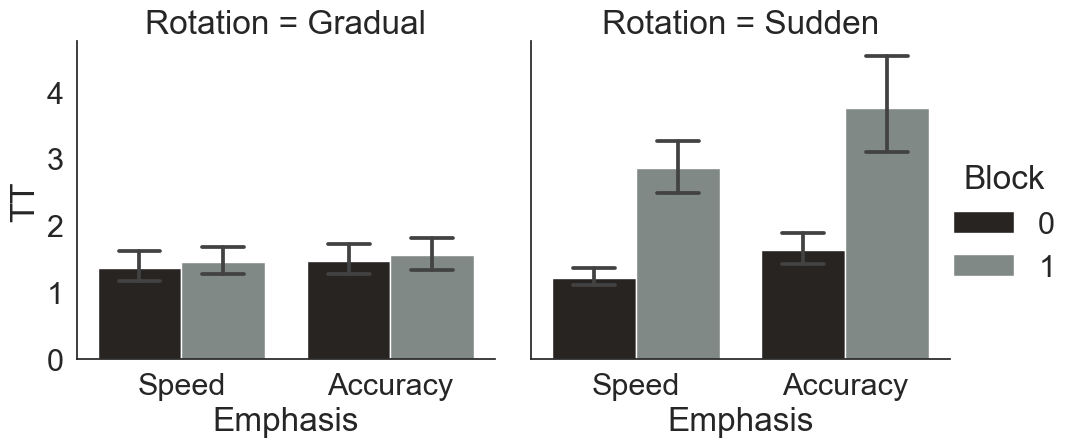

In [9]:
sns.set_context('talk')
sns.set(font_scale = 2)
sns.set_style('white')
colors = [ '#292421', '#808A87']
sns.set_palette(sns.color_palette(colors))

sns.catplot(x = 'Emphasis', y = 'TT', col = 'Rotation', hue = 'Block' ,
            data=df_blockwise.loc[df_blockwise['Block'] <= 1], 
            kind = 'bar', capsize = 0.2, col_order=['Gradual', 'Sudden'], order = ['Speed', 'Accuracy']
            )

# hatches = ['//', '', '//', '']
# for ax in g.axes.flat:
#     patches = [patch for patch in ax.patches]
#     for i, patch in enumerate(patches):
#         patch.set_hatch(hatches[i])


In [10]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

model = ols(
    'TT ~ C(Rotation) * C(Emphasis) * C(Block)', data=df_blockwise.loc[df_blockwise['Block'] <= 1]).fit()
sm.stats.anova_lm(model, typ=2)

sum_sq     df          F        PR(>F)
C(Rotation)                       24.443775    1.0  48.955533  2.028470e-10
C(Emphasis)                        4.247070    1.0   8.505951  4.277398e-03
C(Block)                          29.160252    1.0  58.401605  7.862174e-12
C(Rotation):C(Emphasis)            2.236023    1.0   4.478265  3.654360e-02
C(Rotation):C(Block)              24.418707    1.0  48.905326  2.064919e-10
C(Emphasis):C(Block)               0.426125    1.0   0.853435  3.575685e-01
C(Rotation):C(Emphasis):C(Block)   0.428672    1.0   0.858537  3.561409e-01
Residual                          55.922235  112.0        NaN           NaN

0.004